In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import corpus_bleu
import json
import zipfile
import requests
from io import BytesIO
from collections import Counter
import pickle
from tqdm import tqdm
import random
import time
import shutil
import gc
from google.colab import drive


In [ ]:
# !pip install pycocoevalcap nltk


In [ ]:
# Set device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create project directory in Google Drive
PROJECT_DIR = '/content/drive/MyDrive/image_captioning_project'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/data', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/models', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)

In [ ]:
# Download COCO annotations if not already downloaded
def download_coco_annotations():
    annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

    if not os.path.exists(f'{PROJECT_DIR}/data/annotations'):
        print("Downloading COCO annotations...")
        r = requests.get(annotations_url)
        z = zipfile.ZipFile(BytesIO(r.content))
        z.extractall(f'{PROJECT_DIR}/data')
        print("COCO annotations downloaded and extracted!")
    else:
        print("COCO annotations already exist.")


In [ ]:

# Download and extract COCO images, then select a subset
def download_coco_images(num_images=8000):
    # Create directories
    train_images_dir = f'{PROJECT_DIR}/data/train2017'
    os.makedirs(train_images_dir, exist_ok=True)
    temp_dir = f'{PROJECT_DIR}/data/temp'
    os.makedirs(temp_dir, exist_ok=True)

    # Check if we already have the selected image IDs
    selected_ids_path = f'{PROJECT_DIR}/data/selected_image_ids.pkl'
    if os.path.exists(selected_ids_path):
        print("Loading previously selected image IDs...")
        with open(selected_ids_path, 'rb') as f:
            return pickle.load(f)

    # Check if the train2017 directory already has images
    existing_images = os.listdir(train_images_dir) if os.path.exists(train_images_dir) else []
    if len(existing_images) > 0:
        print(f"Found {len(existing_images)} images already downloaded.")

        # Load captions file to get image IDs
        with open(f'{PROJECT_DIR}/data/annotations/captions_train2017.json', 'r') as f:
            data = json.load(f)

        # Map filenames to image IDs
        filename_to_id = {img['file_name']: img['id'] for img in data['images']}
        selected_image_ids = set()

        # Get image IDs for existing files
        for filename in existing_images:
            if filename in filename_to_id:
                selected_image_ids.add(filename_to_id[filename])

        if len(selected_image_ids) >= num_images:
            print(f"Already have {len(selected_image_ids)} images, which is enough.")
            with open(selected_ids_path, 'wb') as f:
                pickle.dump(selected_image_ids, f)
            return selected_image_ids

    # Download the zip file if needed
    zip_path = f'{temp_dir}/train2017.zip'
    if not os.path.exists(zip_path):
        print("Downloading COCO train2017 images zip file...")
        train_url = 'http://images.cocodataset.org/zips/train2017.zip'

        # Stream download with progress tracking
        response = requests.get(train_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024 * 1024  # 1MB

        with open(zip_path, 'wb') as f:
            for i, data in enumerate(response.iter_content(block_size)):
                f.write(data)
                downloaded = (i + 1) * block_size
                if i % 10 == 0:  # Update progress every 10MB
                    print(f"Downloaded {downloaded/1024/1024:.1f} MB / {total_size/1024/1024:.1f} MB ({100*downloaded/total_size:.1f}%)")

    # Load captions file to get image IDs
    with open(f'{PROJECT_DIR}/data/annotations/captions_train2017.json', 'r') as f:
        data = json.load(f)

    # Get unique image IDs with captions
    all_image_ids = list(set(ann['image_id'] for ann in data['annotations']))

    # Select a subset of images
    selected_image_ids = set(random.sample(all_image_ids, min(num_images, len(all_image_ids))))

    # Create a mapping of image_id to file_name
    image_id_to_filename = {}
    for img in data['images']:
        if img['id'] in selected_image_ids:
            image_id_to_filename[img['id']] = img['file_name']

    # Extract only the selected images from the zip
    print(f"Extracting {len(selected_image_ids)} selected images from zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for img_id in tqdm(selected_image_ids):
            if img_id in image_id_to_filename:
                filename = image_id_to_filename[img_id]
                zip_path = f'train2017/{filename}'

                # Skip if already extracted
                if os.path.exists(f'{train_images_dir}/{filename}'):
                    continue

                try:
                    zip_ref.extract(zip_path, f'{PROJECT_DIR}/data')
                except Exception as e:
                    print(f"Error extracting {filename}: {e}")

    # Save selected image IDs for future reference
    with open(selected_ids_path, 'wb') as f:
        pickle.dump(selected_image_ids, f)

    print(f"Successfully selected and extracted {len(selected_image_ids)} images!")

    # Clean up the temporary zip file to save space
    if os.path.exists(temp_dir):
        print("Cleaning up temporary files...")
        shutil.rmtree(temp_dir)

    return selected_image_ids

In [ ]:
# Preprocess captions and build vocabulary
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(captions, threshold=4):
    counter = Counter()
    for caption in captions:
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

    # Filter words below threshold
    words = [word for word, count in counter.items() if count >= threshold]

    # Create vocabulary
    vocab = Vocabulary()
    vocab.add_word('<pad>')  # padding token
    vocab.add_word('<start>')  # start token
    vocab.add_word('<end>')  # end token
    vocab.add_word('<unk>')  # unknown token

    for word in words:
        vocab.add_word(word)

    return vocab

def preprocess_captions(selected_image_ids):
    with open(f'{PROJECT_DIR}/data/annotations/captions_train2017.json', 'r') as f:
        data = json.load(f)

    # Extract captions for selected images
    captions = []
    image_id_to_captions = {}

    for ann in data['annotations']:
        if ann['image_id'] in selected_image_ids:
            # Clean caption
            caption = ann['caption'].lower()
            caption = ' '.join(nltk.tokenize.word_tokenize(caption))

            captions.append(caption)

            if ann['image_id'] not in image_id_to_captions:
                image_id_to_captions[ann['image_id']] = []

            image_id_to_captions[ann['image_id']].append(caption)

    # Build vocabulary
    vocab = build_vocab(captions)

    # Save vocabulary and image_id_to_captions
    with open(f'{PROJECT_DIR}/data/vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f)

    with open(f'{PROJECT_DIR}/data/image_id_to_captions.pkl', 'wb') as f:
        pickle.dump(image_id_to_captions, f)

    return vocab, image_id_to_captions

In [ ]:
# Create the dataset class
class COCODataset(Dataset):
    def __init__(self, image_dir, image_ids, image_id_to_captions, vocab, transform=None):
        self.image_dir = image_dir
        self.image_id_to_filename = {}
        self.data = []

        # Load image_id to filename mapping
        with open(f'{PROJECT_DIR}/data/annotations/captions_train2017.json', 'r') as f:
            coco_data = json.load(f)

        for img in coco_data['images']:
            if img['id'] in image_ids:
                self.image_id_to_filename[img['id']] = img['file_name']

        # Create data entries: (image_id, caption)
        for img_id in image_ids:
            if img_id in image_id_to_captions:
                for caption in image_id_to_captions[img_id]:
                    self.data.append((img_id, caption))

        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id, caption = self.data[idx]
        img_filename = self.image_id_to_filename[img_id]
        img_path = os.path.join(self.image_dir, img_filename)

        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Process caption
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        caption = []
        caption.append(self.vocab('<start>'))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab('<end>'))

        return image, torch.tensor(caption), img_id


In [ ]:
# Collate function for DataLoader
def collate_fn(data):
    # Sort by caption length (descending)
    data.sort(key=lambda x: len(x[1]), reverse=True)

    images, captions, img_ids = zip(*data)

    # Stack images
    images = torch.stack(images, 0)

    # Get caption lengths
    lengths = [len(cap) for cap in captions]

    # Pad captions
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, lengths, img_ids


In [ ]:
# Encoder: ResNet-based CNN
class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()

        # Load pre-trained ResNet
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

        # Remove linear and pool layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize to fixed size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        # Fine-tune only the last convolutional block
        for param in list(self.resnet.parameters())[:-36]:  # freeze earlier layers
            param.requires_grad = False

    def forward(self, images):
        # Extract feature maps
        features = self.resnet(images)  # (batch_size, 2048, h/32, w/32)
        features = self.adaptive_pool(features)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        features = features.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)

        return features

In [ ]:
# Attention Network
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        # encoder_out: (batch_size, num_pixels, encoder_dim)
        # decoder_hidden: (batch_size, decoder_dim)

        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(F.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)

        alpha = F.softmax(att, dim=1)  # (batch_size, num_pixels)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return context, alpha


In [ ]:
# Decoder with Attention
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, attention_dim, encoder_dim, dropout=0.5):
        super(DecoderRNN, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, hidden_size, attention_dim)

        self.init_h = nn.Linear(encoder_dim, hidden_size)
        self.init_c = nn.Linear(encoder_dim, hidden_size)

        self.lstm = nn.LSTMCell(embed_size + encoder_dim, hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Add a separate gating layer that outputs encoder_dim sized vector
        self.gate_layer = nn.Linear(hidden_size, encoder_dim)

        self.fc = nn.Linear(hidden_size, vocab_size)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        # Mean of encoder output features
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, captions, lengths):
        # Flatten image features
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)

        # Sort by caption length (descending)
        lengths, sort_idx = torch.sort(torch.tensor(lengths), descending=True)
        encoder_out = encoder_out[sort_idx]
        captions = captions[sort_idx]

        # Embedding
        embeddings = self.embedding(captions)  # (batch_size, max_caption_length, embed_size)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, hidden_size)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        decode_lengths = [length-1 for length in lengths]

        # Create tensors to hold word prediction scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), self.vocab_size).to(captions.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), encoder_out.size(1)).to(captions.device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])

            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])

            # Use dedicated gate layer instead of fc layer
            gate = torch.sigmoid(self.gate_layer(h[:batch_size_t]))  # Now outputs correct dimensions
            attention_weighted_encoding = gate * attention_weighted_encoding

            h, c = self.lstm(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t])
            )

            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, captions, decode_lengths, alphas, sort_idx

    def sample(self, encoder_out, states=None, max_len=20):
        """Generate captions for given image features using greedy search."""
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, hidden_size)

        # Create tensors to hold word prediction scores and alphas
        sampled_ids = []
        alphas = []

        # Start token
        start_id = torch.ones(batch_size, 1).long().to(encoder_out.device) * 1  # <start> token id = 1
        embedding = self.embedding(start_id).squeeze(1)

        for i in range(max_len):
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)

            # Also update the gate in the sample method
            gate = torch.sigmoid(self.gate_layer(h))
            attention_weighted_encoding = gate * attention_weighted_encoding

            h, c = self.lstm(
                torch.cat([embedding, attention_weighted_encoding], dim=1),
                (h, c)
            )

            preds = self.fc(h)

            # Store prediction and attention weights
            predicted = preds.argmax(dim=1)
            sampled_ids.append(predicted)
            alphas.append(alpha)

            # Next input is the predicted word
            embedding = self.embedding(predicted)

            # Break if all batches have predicted <end>
            if (predicted == 2).all():  # <end> token id = 2
                break

        sampled_ids = torch.stack(sampled_ids, 1)  # (batch_size, max_len)
        alphas = torch.stack(alphas, 1)  # (batch_size, max_len, num_pixels)

        return sampled_ids, alphas

In [ ]:
# Training function
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    encoder.train()
    decoder.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # Batches
    for i, (imgs, caps, lengths, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        # Move to device
        imgs = imgs.to(device)
        caps = caps.to(device)

        # Forward pass
        features = encoder(imgs)
        predictions, captions, decode_lengths, alphas, sort_idx = decoder(features, caps, lengths)

        # Calculate loss
        targets = captions[:, 1:]  # Remove <start> token

        # Pack predictions
        predictions = pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        # Calculate loss
        loss = criterion(predictions, targets)

        # Add doubly stochastic attention regularization
        alpha_c = 1.0
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Backward pass
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)

        # Update weights
        encoder_optimizer.step()
        decoder_optimizer.step()

        # Keep track of loss
        losses.update(loss.item())

        # Print status
        if i % 100 == 0:
            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                  f'Loss: {losses.val:.4f} ({losses.avg:.4f})')

    return losses.avg

In [ ]:
def evaluate(encoder, decoder, test_loader, vocab):
    encoder.eval()
    decoder.eval()

    references = {}
    hypotheses = {}

    # Use an even smaller subset for evaluation
    max_eval_samples = 100  # Reduced from 500 to 100
    sample_count = 0

    with torch.no_grad():
        for i, (imgs, caps, lengths, img_ids) in enumerate(tqdm(test_loader, desc="Evaluating")):
            # Debug print to see where it might be stuck
            print(f"Processing batch {i}, samples so far: {sample_count}")

            # Move to device
            imgs = imgs.to(device)

            try:
                # Forward pass
                features = encoder(imgs)
                sampled_ids, _ = decoder.sample(features)

                # Convert predicted and target captions to text
                for j, img_id in enumerate(img_ids):
                    if img_id not in references:
                        references[img_id] = []
                        hypotheses[img_id] = []

                    # Predicted caption
                    predicted_caption = []
                    for word_id in sampled_ids[j]:
                        word = vocab.idx2word[word_id.item()]
                        if word == '<end>':
                            break
                        if word not in ['<start>', '<pad>']:
                            predicted_caption.append(word)

                    # Target caption (from current batch)
                    target_caption = []
                    for word_id in caps[j, 1:]:  # Skip <start>
                        word = vocab.idx2word[word_id.item()]
                        if word == '<end>':
                            break
                        if word not in ['<pad>']:
                            target_caption.append(word)

                    references[img_id].append(' '.join(target_caption))
                    hypotheses[img_id].append(' '.join(predicted_caption))

                    sample_count += 1

                # Limit number of samples to evaluate
                if sample_count >= max_eval_samples:
                    break

            except Exception as e:
                print(f"Error in batch {i}: {e}")
                continue  # Skip problematic batches

    print("Calculating BLEU scores...")
    # Calculate BLEU scores (always available)
    references_for_bleu = []
    hypotheses_for_bleu = []

    for img_id in references.keys():
        refs = []
        for ref in references[img_id]:
            refs.append(ref.split())
        references_for_bleu.append(refs)
        hypotheses_for_bleu.append(hypotheses[img_id][0].split())

    bleu1 = corpus_bleu(references_for_bleu, hypotheses_for_bleu, weights=(1, 0, 0, 0))
    bleu4 = corpus_bleu(references_for_bleu, hypotheses_for_bleu, weights=(0.25, 0.25, 0.25, 0.25))

    # Return only BLEU scores for now
    return {
        'BLEU-1': bleu1,
        'BLEU-4': bleu4,
    }

In [ ]:

# Utility function
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# Install required packages
print("Installing required packages...")

# Install NLTK and download punkt
try:
    import nltk
    nltk.download('punkt')
except:
    !pip install -q nltk
    import nltk
    nltk.download('punkt')

Installing required packages...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Install evaluation metrics
!pip install -q pycocoevalcap

# Importing evaluation metrics (after installation)
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Download and prepare data
print("\n=== Preparing Dataset ===")
download_coco_annotations()
selected_image_ids = download_coco_images(num_images=8000)  # Increased to 8000 images


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
vocab, image_id_to_captions = preprocess_captions(selected_image_ids)

In [ ]:
# Print dataset stats
print(f"\nDataset Statistics:")
print(f"- Number of images: {len(selected_image_ids)}")
print(f"- Vocabulary size: {len(vocab)}")


Dataset Statistics:
- Number of images: 8000
- Vocabulary size: 3466


In [ ]:
# Split data into train and validation sets
train_ids = list(selected_image_ids)[:int(0.85 * len(selected_image_ids))]  # Increased train ratio
val_ids = list(selected_image_ids)[int(0.85 * len(selected_image_ids)):]
print(f"- Training images: {len(train_ids)}")
print(f"- Validation images: {len(val_ids)}")

- Training images: 6800
- Validation images: 1200


In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
# Create datasets
print("\nCreating datasets...")
train_dataset = COCODataset(
    image_dir=f'{PROJECT_DIR}/data/train2017',
    image_ids=train_ids,
    image_id_to_captions=image_id_to_captions,
    vocab=vocab,
    transform=transform
)


Creating datasets...


In [ ]:
val_dataset = COCODataset(
    image_dir=f'{PROJECT_DIR}/data/train2017',
    image_ids=val_ids,
    image_id_to_captions=image_id_to_captions,
    vocab=vocab,
    transform=transform
)

In [ ]:
# Create data loaders with fewer workers for Colab
print("Creating data loaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,  # Reduced for Colab
    collate_fn=collate_fn
)

Creating data loaders...


In [ ]:
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,  # Reduced for Colab
    collate_fn=collate_fn
)

In [ ]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


Using device: cuda


In [ ]:
# Initialize models
print("Initializing models...")
encoder = EncoderCNN().to(device)
decoder = DecoderRNN(
    embed_size=256,
    hidden_size=512,
    vocab_size=len(vocab),
    attention_dim=512,
    encoder_dim=2048,
    dropout=0.5
).to(device)

Initializing models...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
encoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, encoder.parameters()), lr=1e-4)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=4e-4)

In [ ]:
# Check for existing checkpoint
checkpoint_path = f'{PROJECT_DIR}/models/checkpoint.pth'
start_epoch = 0
best_bleu4 = 0.0

In [ ]:
# Add this before trying to load the checkpoint
import torch.serialization
torch.serialization.add_safe_globals(['Vocabulary', '__main__.Vocabulary'])

In [ ]:
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer'])
    decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer'])
    start_epoch = checkpoint['epoch'] + 1
    best_bleu4 = checkpoint.get('best_bleu4', 0.0)
    print(f"Resuming from epoch {start_epoch} with BLEU-4: {best_bleu4:.4f}")

In [ ]:
# Training loop
print("\n=== Starting Training ===")
num_epochs = 10

for epoch in range(start_epoch, num_epochs):
    start_time = time.time()

    # Train
    train_loss = train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch)

    # Save checkpoint after each epoch (for resuming training if interrupted)
    torch.save({
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict(),
        'encoder_optimizer': encoder_optimizer.state_dict(),
        'decoder_optimizer': decoder_optimizer.state_dict(),
        'vocab': vocab,
        'epoch': epoch,
        'best_bleu4': best_bleu4
    }, checkpoint_path)

    # Clear memory
    torch.cuda.empty_cache()
    gc.collect()

    # Evaluate (less frequently to save time)
    # if epoch % 2 == 0 or epoch == num_epochs - 1:
    if epoch >= 3 and (epoch % 2 == 0 or epoch == num_epochs - 1):
        print("Evaluating model...")
        metrics = evaluate(encoder, decoder, val_loader, vocab)

        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs} (Time: {(time.time() - start_time)/60:.2f} mins):")
        print(f"Train Loss: {train_loss:.4f}")
        for metric, score in metrics.items():
            print(f"{metric}: {score:.4f}")

        # Save best model based on BLEU-4 score
        if metrics['BLEU-4'] > best_bleu4:
            best_bleu4 = metrics['BLEU-4']

            # Save models
            torch.save({
                'encoder': encoder.state_dict(),
                'decoder': decoder.state_dict(),
                'encoder_optimizer': encoder_optimizer.state_dict(),
                'decoder_optimizer': decoder_optimizer.state_dict(),
                'vocab': vocab,
                'epoch': epoch,
                'metrics': metrics,
                'best_bleu4': best_bleu4
            }, f'{PROJECT_DIR}/models/best_model.pth')

            print(f"New best model saved with BLEU-4: {best_bleu4:.4f}")
    else:
        print(f"\nEpoch {epoch+1}/{num_epochs} (Time: {(time.time() - start_time)/60:.2f} mins):")
        print(f"Train Loss: {train_loss:.4f}")
        print("Skipping evaluation this epoch to save time")


=== Starting Training ===


Epoch 0:   0%|          | 1/1063 [00:01<21:26,  1.21s/it]

Epoch: [0][0/1063]	Loss: 3.6159 (3.6159)


Epoch 0:  10%|▉         | 101/1063 [00:47<06:50,  2.35it/s]

Epoch: [0][100/1063]	Loss: 4.2871 (4.0460)


Epoch 0:  19%|█▉        | 201/1063 [01:33<07:57,  1.81it/s]

Epoch: [0][200/1063]	Loss: 3.9586 (4.0089)


Epoch 0:  28%|██▊       | 301/1063 [02:19<05:44,  2.21it/s]

Epoch: [0][300/1063]	Loss: 3.9504 (3.9926)


Epoch 0:  38%|███▊      | 401/1063 [03:06<04:50,  2.28it/s]

Epoch: [0][400/1063]	Loss: 4.0486 (3.9827)


Epoch 0:  47%|████▋     | 501/1063 [03:51<04:02,  2.32it/s]

Epoch: [0][500/1063]	Loss: 4.1644 (3.9770)


Epoch 0:  57%|█████▋    | 601/1063 [04:37<03:36,  2.13it/s]

Epoch: [0][600/1063]	Loss: 3.5947 (3.9661)


Epoch 0:  66%|██████▌   | 701/1063 [05:22<02:49,  2.13it/s]

Epoch: [0][700/1063]	Loss: 3.9102 (3.9564)


Epoch 0:  75%|███████▌  | 801/1063 [06:08<01:53,  2.31it/s]

Epoch: [0][800/1063]	Loss: 3.5620 (3.9480)


Epoch 0:  85%|████████▍ | 901/1063 [06:54<01:07,  2.39it/s]

Epoch: [0][900/1063]	Loss: 3.8437 (3.9317)


Epoch 0:  94%|█████████▍| 1001/1063 [07:39<00:26,  2.31it/s]

Epoch: [0][1000/1063]	Loss: 3.8200 (3.9246)


Epoch 0: 100%|██████████| 1063/1063 [08:07<00:00,  2.18it/s]



Epoch 1/10 (Time: 8.17 mins):
Train Loss: 3.9173
Skipping evaluation this epoch to save time


Epoch 1:   0%|          | 1/1063 [00:01<24:19,  1.37s/it]

Epoch: [1][0/1063]	Loss: 3.5833 (3.5833)


Epoch 1:  10%|▉         | 101/1063 [00:47<07:07,  2.25it/s]

Epoch: [1][100/1063]	Loss: 3.6376 (3.6962)


Epoch 1:  19%|█▉        | 201/1063 [01:31<06:09,  2.34it/s]

Epoch: [1][200/1063]	Loss: 3.4528 (3.6888)


Epoch 1:  28%|██▊       | 301/1063 [02:18<05:32,  2.29it/s]

Epoch: [1][300/1063]	Loss: 3.4581 (3.6990)


Epoch 1:  38%|███▊      | 401/1063 [07:08<04:58,  2.22it/s]

Epoch: [1][400/1063]	Loss: 3.7756 (3.6940)


Epoch 1:  47%|████▋     | 501/1063 [07:54<04:04,  2.30it/s]

Epoch: [1][500/1063]	Loss: 3.4887 (3.6858)


Epoch 1:  57%|█████▋    | 601/1063 [08:40<03:40,  2.10it/s]

Epoch: [1][600/1063]	Loss: 3.7096 (3.6852)


Epoch 1:  66%|██████▌   | 701/1063 [09:28<02:44,  2.20it/s]

Epoch: [1][700/1063]	Loss: 3.9095 (3.6769)


Epoch 1:  75%|███████▌  | 801/1063 [10:14<02:07,  2.06it/s]

Epoch: [1][800/1063]	Loss: 3.8998 (3.6722)


Epoch 1:  85%|████████▍ | 901/1063 [11:01<01:09,  2.32it/s]

Epoch: [1][900/1063]	Loss: 3.5440 (3.6700)


Epoch 1:  94%|█████████▍| 1001/1063 [11:48<00:30,  2.05it/s]

Epoch: [1][1000/1063]	Loss: 3.6888 (3.6631)


Epoch 1: 100%|██████████| 1063/1063 [12:17<00:00,  1.44it/s]



Epoch 2/10 (Time: 12.40 mins):
Train Loss: 3.6613
Skipping evaluation this epoch to save time


Epoch 2:   0%|          | 1/1063 [00:01<25:42,  1.45s/it]

Epoch: [2][0/1063]	Loss: 3.2727 (3.2727)


Epoch 2:  10%|▉         | 101/1063 [00:49<07:32,  2.12it/s]

Epoch: [2][100/1063]	Loss: 3.4394 (3.4972)


Epoch 2:  19%|█▉        | 201/1063 [01:35<06:08,  2.34it/s]

Epoch: [2][200/1063]	Loss: 3.5036 (3.5058)


Epoch 2:  28%|██▊       | 301/1063 [02:20<05:24,  2.35it/s]

Epoch: [2][300/1063]	Loss: 3.5882 (3.5046)


Epoch 2:  38%|███▊      | 401/1063 [03:06<05:30,  2.00it/s]

Epoch: [2][400/1063]	Loss: 3.4569 (3.4979)


Epoch 2:  47%|████▋     | 501/1063 [03:52<04:50,  1.93it/s]

Epoch: [2][500/1063]	Loss: 3.3213 (3.5068)


Epoch 2:  57%|█████▋    | 601/1063 [04:42<03:14,  2.37it/s]

Epoch: [2][600/1063]	Loss: 3.6576 (3.5094)


Epoch 2:  66%|██████▌   | 701/1063 [05:27<02:51,  2.11it/s]

Epoch: [2][700/1063]	Loss: 3.5722 (3.5062)


Epoch 2:  75%|███████▌  | 801/1063 [06:13<02:10,  2.01it/s]

Epoch: [2][800/1063]	Loss: 3.5912 (3.5022)


Epoch 2:  85%|████████▍ | 901/1063 [06:59<01:09,  2.34it/s]

Epoch: [2][900/1063]	Loss: 3.6769 (3.4980)


Epoch 2:  94%|█████████▍| 1001/1063 [07:44<00:27,  2.25it/s]

Epoch: [2][1000/1063]	Loss: 3.5342 (3.4941)


Epoch 2: 100%|██████████| 1063/1063 [08:14<00:00,  2.15it/s]



Epoch 3/10 (Time: 8.27 mins):
Train Loss: 3.4910
Skipping evaluation this epoch to save time


Epoch 3:   0%|          | 1/1063 [00:01<35:19,  2.00s/it]

Epoch: [3][0/1063]	Loss: 3.4578 (3.4578)


Epoch 3:  10%|▉         | 101/1063 [00:57<07:30,  2.14it/s]

Epoch: [3][100/1063]	Loss: 3.3888 (3.3380)


Epoch 3:  19%|█▉        | 201/1063 [01:44<06:49,  2.11it/s]

Epoch: [3][200/1063]	Loss: 3.0883 (3.3455)


Epoch 3:  28%|██▊       | 301/1063 [02:30<05:28,  2.32it/s]

Epoch: [3][300/1063]	Loss: 3.3454 (3.3530)


Epoch 3:  38%|███▊      | 401/1063 [03:15<04:40,  2.36it/s]

Epoch: [3][400/1063]	Loss: 3.4247 (3.3614)


Epoch 3:  47%|████▋     | 501/1063 [04:01<04:21,  2.15it/s]

Epoch: [3][500/1063]	Loss: 3.2495 (3.3646)


Epoch 3:  57%|█████▋    | 601/1063 [04:47<03:26,  2.24it/s]

Epoch: [3][600/1063]	Loss: 3.4555 (3.3648)


Epoch 3:  66%|██████▌   | 701/1063 [05:32<02:37,  2.30it/s]

Epoch: [3][700/1063]	Loss: 3.0067 (3.3650)


Epoch 3:  75%|███████▌  | 801/1063 [06:18<01:49,  2.40it/s]

Epoch: [3][800/1063]	Loss: 3.3604 (3.3597)


Epoch 3:  85%|████████▍ | 901/1063 [07:03<01:09,  2.34it/s]

Epoch: [3][900/1063]	Loss: 3.2913 (3.3558)


Epoch 3:  94%|█████████▍| 1001/1063 [07:50<00:30,  2.00it/s]

Epoch: [3][1000/1063]	Loss: 3.4259 (3.3564)


Epoch 3: 100%|██████████| 1063/1063 [08:19<00:00,  2.13it/s]



Epoch 4/10 (Time: 8.37 mins):
Train Loss: 3.3564
Skipping evaluation this epoch to save time


Epoch 4:   0%|          | 1/1063 [00:02<52:38,  2.97s/it]

Epoch: [4][0/1063]	Loss: 3.2034 (3.2034)


Epoch 4:  10%|▉         | 101/1063 [00:56<07:01,  2.28it/s]

Epoch: [4][100/1063]	Loss: 2.9692 (3.2139)


Epoch 4:  19%|█▉        | 201/1063 [01:42<06:05,  2.36it/s]

Epoch: [4][200/1063]	Loss: 3.4378 (3.2233)


Epoch 4:  28%|██▊       | 301/1063 [02:27<05:25,  2.34it/s]

Epoch: [4][300/1063]	Loss: 3.2012 (3.2328)


Epoch 4:  38%|███▊      | 401/1063 [03:14<05:27,  2.02it/s]

Epoch: [4][400/1063]	Loss: 3.1210 (3.2405)


Epoch 4:  47%|████▋     | 501/1063 [03:59<04:23,  2.13it/s]

Epoch: [4][500/1063]	Loss: 3.1768 (3.2434)


Epoch 4:  57%|█████▋    | 601/1063 [04:44<03:16,  2.35it/s]

Epoch: [4][600/1063]	Loss: 3.2812 (3.2422)


Epoch 4:  66%|██████▌   | 701/1063 [05:29<02:31,  2.39it/s]

Epoch: [4][700/1063]	Loss: 3.1580 (3.2449)


Epoch 4:  75%|███████▌  | 801/1063 [06:15<02:00,  2.17it/s]

Epoch: [4][800/1063]	Loss: 3.1402 (3.2466)


Epoch 4:  85%|████████▍ | 901/1063 [07:02<01:16,  2.11it/s]

Epoch: [4][900/1063]	Loss: 3.1870 (3.2457)


Epoch 4:  94%|█████████▍| 1001/1063 [07:47<00:26,  2.35it/s]

Epoch: [4][1000/1063]	Loss: 3.5617 (3.2482)


Epoch 4: 100%|██████████| 1063/1063 [08:15<00:00,  2.14it/s]


Evaluating model...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   1%|          | 1/188 [00:01<03:47,  1.22s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/188 [00:01<02:05,  1.48it/s]

Processing batch 2, samples so far: 64


Evaluating:   2%|▏         | 3/188 [00:01<01:31,  2.01it/s]

Processing batch 3, samples so far: 96


Evaluating:   2%|▏         | 3/188 [00:02<02:16,  1.35it/s]


Calculating BLEU scores...

Epoch 5/10 (Time: 8.34 mins):
Train Loss: 3.2497
BLEU-1: 0.6967
BLEU-4: 0.2284
New best model saved with BLEU-4: 0.2284


Epoch 5:   0%|          | 1/1063 [00:01<34:38,  1.96s/it]

Epoch: [5][0/1063]	Loss: 2.9949 (2.9949)


Epoch 5:  10%|▉         | 101/1063 [00:56<07:31,  2.13it/s]

Epoch: [5][100/1063]	Loss: 3.1976 (3.1250)


Epoch 5:  19%|█▉        | 201/1063 [01:42<06:50,  2.10it/s]

Epoch: [5][200/1063]	Loss: 3.0388 (3.1328)


Epoch 5:  28%|██▊       | 301/1063 [02:29<05:29,  2.31it/s]

Epoch: [5][300/1063]	Loss: 3.2818 (3.1467)


Epoch 5:  38%|███▊      | 401/1063 [03:14<04:47,  2.30it/s]

Epoch: [5][400/1063]	Loss: 3.0721 (3.1542)


Epoch 5:  47%|████▋     | 501/1063 [04:00<04:46,  1.96it/s]

Epoch: [5][500/1063]	Loss: 3.1991 (3.1534)


Epoch 5:  57%|█████▋    | 601/1063 [04:45<03:33,  2.17it/s]

Epoch: [5][600/1063]	Loss: 2.9221 (3.1512)


Epoch 5:  66%|██████▌   | 701/1063 [05:31<02:34,  2.35it/s]

Epoch: [5][700/1063]	Loss: 3.0594 (3.1533)


Epoch 5:  75%|███████▌  | 801/1063 [06:17<01:50,  2.37it/s]

Epoch: [5][800/1063]	Loss: 3.2553 (3.1551)


Epoch 5:  85%|████████▍ | 901/1063 [07:02<01:08,  2.35it/s]

Epoch: [5][900/1063]	Loss: 3.1358 (3.1549)


Epoch 5:  94%|█████████▍| 1001/1063 [07:48<00:33,  1.85it/s]

Epoch: [5][1000/1063]	Loss: 3.1925 (3.1558)


Epoch 5: 100%|██████████| 1063/1063 [08:15<00:00,  2.14it/s]



Epoch 6/10 (Time: 8.30 mins):
Train Loss: 3.1539
Skipping evaluation this epoch to save time


Epoch 6:   0%|          | 1/1063 [00:01<22:07,  1.25s/it]

Epoch: [6][0/1063]	Loss: 2.7249 (2.7249)


Epoch 6:  10%|▉         | 101/1063 [00:54<07:40,  2.09it/s]

Epoch: [6][100/1063]	Loss: 2.8558 (3.0269)


Epoch 6:  19%|█▉        | 201/1063 [01:41<06:14,  2.30it/s]

Epoch: [6][200/1063]	Loss: 3.2240 (3.0381)


Epoch 6:  28%|██▊       | 301/1063 [02:26<05:40,  2.24it/s]

Epoch: [6][300/1063]	Loss: 3.2543 (3.0434)


Epoch 6:  38%|███▊      | 401/1063 [03:12<04:53,  2.25it/s]

Epoch: [6][400/1063]	Loss: 2.9858 (3.0485)


Epoch 6:  47%|████▋     | 501/1063 [03:58<04:48,  1.94it/s]

Epoch: [6][500/1063]	Loss: 3.0424 (3.0550)


Epoch 6:  57%|█████▋    | 601/1063 [04:43<03:26,  2.24it/s]

Epoch: [6][600/1063]	Loss: 3.0063 (3.0596)


Epoch 6:  66%|██████▌   | 701/1063 [05:29<02:37,  2.30it/s]

Epoch: [6][700/1063]	Loss: 3.0379 (3.0583)


Epoch 6:  75%|███████▌  | 801/1063 [06:14<01:52,  2.32it/s]

Epoch: [6][800/1063]	Loss: 3.1727 (3.0596)


Epoch 6:  85%|████████▍ | 901/1063 [07:00<01:23,  1.93it/s]

Epoch: [6][900/1063]	Loss: 3.0512 (3.0637)


Epoch 6:  94%|█████████▍| 1001/1063 [07:45<00:29,  2.14it/s]

Epoch: [6][1000/1063]	Loss: 3.1277 (3.0681)


Epoch 6: 100%|██████████| 1063/1063 [08:13<00:00,  2.15it/s]


Evaluating model...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   1%|          | 1/188 [00:01<03:22,  1.08s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/188 [00:01<01:54,  1.62it/s]

Processing batch 2, samples so far: 64


Evaluating:   2%|▏         | 3/188 [00:01<01:28,  2.08it/s]

Processing batch 3, samples so far: 96


Evaluating:   2%|▏         | 3/188 [00:02<02:12,  1.40it/s]


Calculating BLEU scores...

Epoch 7/10 (Time: 8.30 mins):
Train Loss: 3.0675
BLEU-1: 0.7000
BLEU-4: 0.2151


Epoch 7:   0%|          | 1/1063 [00:01<19:57,  1.13s/it]

Epoch: [7][0/1063]	Loss: 3.1016 (3.1016)


Epoch 7:  10%|▉         | 101/1063 [00:56<07:13,  2.22it/s]

Epoch: [7][100/1063]	Loss: 2.9943 (2.9524)


Epoch 7:  19%|█▉        | 201/1063 [01:41<06:07,  2.34it/s]

Epoch: [7][200/1063]	Loss: 3.0082 (2.9557)


Epoch 7:  28%|██▊       | 301/1063 [02:26<05:46,  2.20it/s]

Epoch: [7][300/1063]	Loss: 3.0741 (2.9613)


Epoch 7:  38%|███▊      | 401/1063 [03:12<05:34,  1.98it/s]

Epoch: [7][400/1063]	Loss: 2.8994 (2.9662)


Epoch 7:  47%|████▋     | 501/1063 [03:57<04:08,  2.26it/s]

Epoch: [7][500/1063]	Loss: 2.9628 (2.9695)


Epoch 7:  57%|█████▋    | 601/1063 [04:44<03:16,  2.35it/s]

Epoch: [7][600/1063]	Loss: 2.8838 (2.9740)


Epoch 7:  66%|██████▌   | 701/1063 [05:29<02:38,  2.28it/s]

Epoch: [7][700/1063]	Loss: 3.0954 (2.9768)


Epoch 7:  75%|███████▌  | 801/1063 [06:16<02:17,  1.90it/s]

Epoch: [7][800/1063]	Loss: 3.0140 (2.9813)


Epoch 7:  85%|████████▍ | 901/1063 [07:02<01:09,  2.34it/s]

Epoch: [7][900/1063]	Loss: 2.9925 (2.9833)


Epoch 7:  94%|█████████▍| 1001/1063 [07:48<00:26,  2.30it/s]

Epoch: [7][1000/1063]	Loss: 3.1878 (2.9853)


Epoch 7: 100%|██████████| 1063/1063 [08:17<00:00,  2.13it/s]



Epoch 8/10 (Time: 8.33 mins):
Train Loss: 2.9879
Skipping evaluation this epoch to save time


Epoch 8:   0%|          | 1/1063 [00:01<23:45,  1.34s/it]

Epoch: [8][0/1063]	Loss: 2.8384 (2.8384)


Epoch 8:  10%|▉         | 101/1063 [00:56<06:54,  2.32it/s]

Epoch: [8][100/1063]	Loss: 2.7840 (2.8747)


Epoch 8:  19%|█▉        | 201/1063 [01:42<06:53,  2.09it/s]

Epoch: [8][200/1063]	Loss: 2.6950 (2.8620)


Epoch 8:  28%|██▊       | 301/1063 [02:28<06:02,  2.10it/s]

Epoch: [8][300/1063]	Loss: 3.0329 (2.8777)


Epoch 8:  38%|███▊      | 401/1063 [03:13<04:45,  2.32it/s]

Epoch: [8][400/1063]	Loss: 2.8056 (2.8846)


Epoch 8:  47%|████▋     | 501/1063 [03:59<04:04,  2.30it/s]

Epoch: [8][500/1063]	Loss: 3.0267 (2.8889)


Epoch 8:  57%|█████▋    | 601/1063 [04:44<03:14,  2.37it/s]

Epoch: [8][600/1063]	Loss: 3.0465 (2.8949)


Epoch 8:  66%|██████▌   | 701/1063 [05:29<03:08,  1.92it/s]

Epoch: [8][700/1063]	Loss: 2.9074 (2.9008)


Epoch 8:  75%|███████▌  | 801/1063 [06:15<01:58,  2.20it/s]

Epoch: [8][800/1063]	Loss: 2.9127 (2.9052)


Epoch 8:  85%|████████▍ | 901/1063 [07:00<01:08,  2.35it/s]

Epoch: [8][900/1063]	Loss: 2.9429 (2.9106)


Epoch 8:  94%|█████████▍| 1001/1063 [07:46<00:26,  2.36it/s]

Epoch: [8][1000/1063]	Loss: 2.8187 (2.9123)


Epoch 8: 100%|██████████| 1063/1063 [08:14<00:00,  2.15it/s]


Evaluating model...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   1%|          | 1/188 [00:01<04:17,  1.38s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/188 [00:01<02:25,  1.28it/s]

Processing batch 2, samples so far: 64


Evaluating:   2%|▏         | 3/188 [00:02<02:00,  1.53it/s]

Processing batch 3, samples so far: 96


Evaluating:   2%|▏         | 3/188 [00:03<03:05,  1.00s/it]


Calculating BLEU scores...

Epoch 9/10 (Time: 8.33 mins):
Train Loss: 2.9135
BLEU-1: 0.6633
BLEU-4: 0.1859


Epoch 9:   0%|          | 1/1063 [00:01<30:07,  1.70s/it]

Epoch: [9][0/1063]	Loss: 2.6576 (2.6576)


Epoch 9:  10%|▉         | 101/1063 [00:54<07:16,  2.21it/s]

Epoch: [9][100/1063]	Loss: 2.7904 (2.7842)


Epoch 9:  19%|█▉        | 201/1063 [01:40<06:44,  2.13it/s]

Epoch: [9][200/1063]	Loss: 2.8964 (2.7947)


Epoch 9:  28%|██▊       | 301/1063 [02:25<05:42,  2.23it/s]

Epoch: [9][300/1063]	Loss: 2.9276 (2.8064)


Epoch 9:  38%|███▊      | 401/1063 [03:11<05:14,  2.11it/s]

Epoch: [9][400/1063]	Loss: 2.9689 (2.8066)


Epoch 9:  47%|████▋     | 501/1063 [03:56<04:02,  2.32it/s]

Epoch: [9][500/1063]	Loss: 2.8478 (2.8112)


Epoch 9:  57%|█████▋    | 601/1063 [04:42<03:54,  1.97it/s]

Epoch: [9][600/1063]	Loss: 2.7101 (2.8179)


Epoch 9:  66%|██████▌   | 701/1063 [05:28<02:45,  2.18it/s]

Epoch: [9][700/1063]	Loss: 2.9279 (2.8262)


Epoch 9:  75%|███████▌  | 801/1063 [06:13<01:49,  2.38it/s]

Epoch: [9][800/1063]	Loss: 2.8267 (2.8312)


Epoch 9:  85%|████████▍ | 901/1063 [06:58<01:09,  2.34it/s]

Epoch: [9][900/1063]	Loss: 2.7825 (2.8366)


Epoch 9:  94%|█████████▍| 1001/1063 [07:46<00:30,  2.05it/s]

Epoch: [9][1000/1063]	Loss: 2.9036 (2.8389)


Epoch 9: 100%|██████████| 1063/1063 [08:13<00:00,  2.15it/s]


Evaluating model...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   1%|          | 1/188 [00:01<03:36,  1.16s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/188 [00:01<02:07,  1.46it/s]

Processing batch 2, samples so far: 64


Evaluating:   2%|▏         | 3/188 [00:01<01:33,  1.99it/s]

Processing batch 3, samples so far: 96


Evaluating:   2%|▏         | 3/188 [00:02<02:15,  1.37it/s]


Calculating BLEU scores...

Epoch 10/10 (Time: 8.31 mins):
Train Loss: 2.8415
BLEU-1: 0.7128
BLEU-4: 0.2597
New best model saved with BLEU-4: 0.2597


In [ ]:
# Fix checkpoint loading issues by using weights_only=False (needed for custom classes like Vocabulary)
def safe_load_checkpoint(checkpoint_path, device):
    try:
        return torch.load(checkpoint_path, map_location=device, weights_only=False)
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None

In [ ]:
# Final evaluation with best model
print("\n=== Final Evaluation ===")
best_model_path = f'{PROJECT_DIR}/models/best_model.pth'
if os.path.exists(best_model_path):
    print("Loading best model for final evaluation...")
    checkpoint = safe_load_checkpoint(best_model_path, device)
    if checkpoint is not None:
        encoder.load_state_dict(checkpoint['encoder'])
        decoder.load_state_dict(checkpoint['decoder'])

        final_metrics = evaluate(encoder, decoder, val_loader, vocab)

        # Print final results
        print("\nFinal Evaluation Results:")
        for metric, score in final_metrics.items():
            print(f"{metric}: {score:.4f}")

        # Save final results
        with open(f'{PROJECT_DIR}/results/final_metrics.json', 'w') as f:
            json.dump(final_metrics, f)
    else:
        print("Couldn't load best model, using current model for final evaluation")
        # Use current model for evaluation
        final_metrics = evaluate(encoder, decoder, val_loader, vocab)
        print("\nFinal Evaluation Results (with current model):")
        for metric, score in final_metrics.items():
            print(f"{metric}: {score:.4f}")
else:
    print("No best model found, using current model for final evaluation")
    # Use current model for evaluation
    final_metrics = evaluate(encoder, decoder, val_loader, vocab)
    print("\nFinal Evaluation Results (with current model):")
    for metric, score in final_metrics.items():
        print(f"{metric}: {score:.4f}")


=== Final Evaluation ===
Loading best model for final evaluation...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   1%|          | 1/188 [00:01<03:21,  1.08s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/188 [00:01<01:54,  1.62it/s]

Processing batch 2, samples so far: 64


Evaluating:   2%|▏         | 3/188 [00:01<01:33,  1.99it/s]

Processing batch 3, samples so far: 96


Evaluating:   2%|▏         | 3/188 [00:02<02:31,  1.22it/s]

Calculating BLEU scores...

Final Evaluation Results:
BLEU-1: 0.7270
BLEU-4: 0.2500


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import os
from google.colab import drive

# Mount Google Drive if not already mounted
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

# Path to project directory
PROJECT_DIR = '/content/drive/MyDrive/image_captioning_project'

# Load vocabulary
with open(f'{PROJECT_DIR}/data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize models (same architecture as training)
encoder = EncoderCNN().to(device)
decoder = DecoderRNN(
    embed_size=256,
    hidden_size=512,
    vocab_size=len(vocab),
    attention_dim=512,
    encoder_dim=2048,
    dropout=0.5
).to(device)

# Load best model
def safe_load_checkpoint(checkpoint_path, device):
    try:
        return torch.load(checkpoint_path, map_location=device, weights_only=False)
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None

best_model_path = f'{PROJECT_DIR}/models/best_model.pth'
if os.path.exists(best_model_path):
    print("Loading best model...")
    checkpoint = safe_load_checkpoint(best_model_path, device)
    if checkpoint is not None:
        encoder.load_state_dict(checkpoint['encoder'])
        decoder.load_state_dict(checkpoint['decoder'])
        print("Model loaded successfully!")
    else:
        print("Failed to load best model")
else:
    print(f"Model not found at {best_model_path}")

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def caption_image(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    # Generate caption
    with torch.no_grad():
        # Generate feature vector
        features = encoder(image_tensor)

        # Generate caption
        sampled_ids, alphas = decoder.sample(features)
        sampled_ids = sampled_ids[0].cpu().numpy()

    # Convert word IDs to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        if word == '<end>':
            break
        if word not in ['<start>', '<pad>']:
            sampled_caption.append(word)

    # Join words to form sentence
    sentence = ' '.join(sampled_caption)

    # Capitalize first letter and add period
    sentence = sentence.capitalize()
    if not sentence.endswith('.'):
        sentence += '.'

    return sentence, alphas

def visualize_caption(image_path, caption, alphas=None):
    """Visualize image with its caption"""
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(10, 6))

    # Show image
    plt.subplot(1, 1, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Show attention weights if available
    if alphas is not None and False:  # Disabled for now as it needs additional implementation
        # This would show attention visualization
        pass

    # Display caption
    plt.suptitle(f'Caption: {caption}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to test on multiple images
def test_on_images(image_paths):
    """Test model on multiple images"""
    for img_path in image_paths:
        caption, alphas = caption_image(img_path)
        print(f"Image: {os.path.basename(img_path)}")
        print(f"Caption: {caption}\n")
        visualize_caption(img_path, caption, alphas)

# Test on images
# You can provide paths to your test images
test_images = [
    # Add paths to your test images here, for example:
    '/content/drive/MyDrive/image_captioning_project/test_images/test1.jpeg',
    # '/content/drive/MyDrive/image_captioning_project/test_images/image2.jpg',
]

# You can also use random images from the COCO validation set
def test_on_random_coco_images(num_images=5):
    """Test model on random images from COCO validation set"""
    train_dir = f'{PROJECT_DIR}/data/train2017'
    all_images = os.listdir(train_dir)
    import random
    sample_images = random.sample(all_images, min(num_images, len(all_images)))

    image_paths = [os.path.join(train_dir, img) for img in sample_images]
    test_on_images(image_paths)

# Uncomment to test on random COCO images
# test_on_random_coco_images(5)

# Uncomment to test on your custom images
# test_on_images(test_images)

Image: 000000523418.jpg
Caption: A dog standing on top of a field with a frisbee in the background .



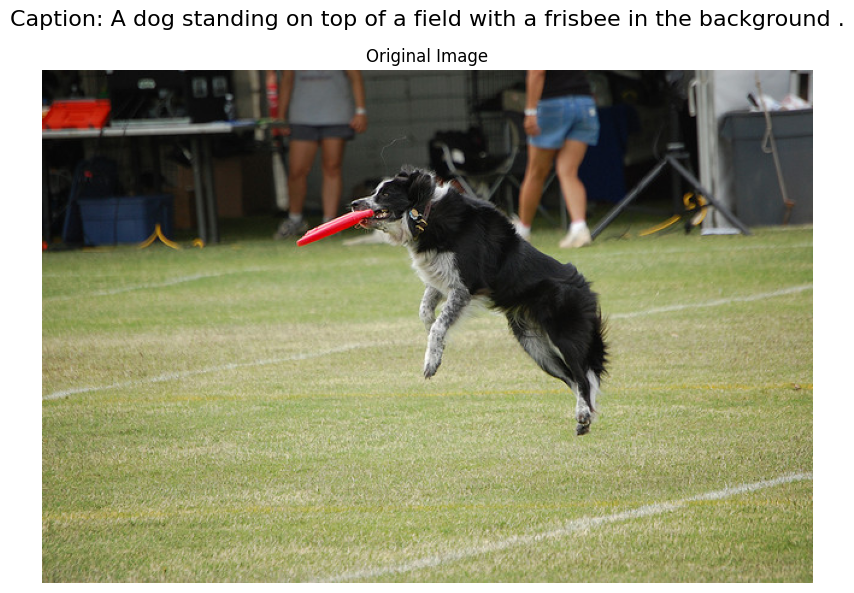

Image: 000000304818.jpg
Caption: A plate with a hot dog and onions .



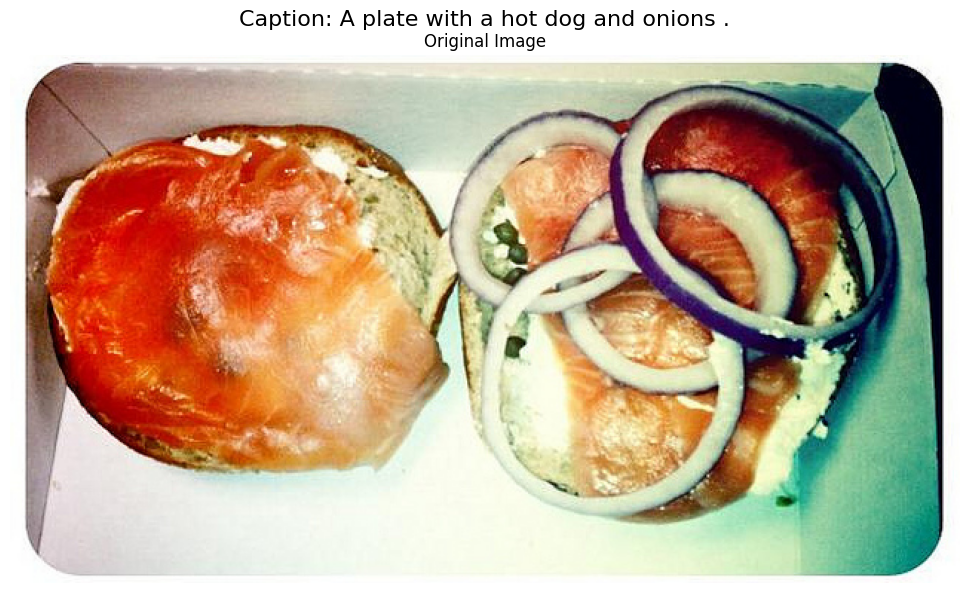

Image: 000000250451.jpg
Caption: A skier is skiing down a snowy slope .



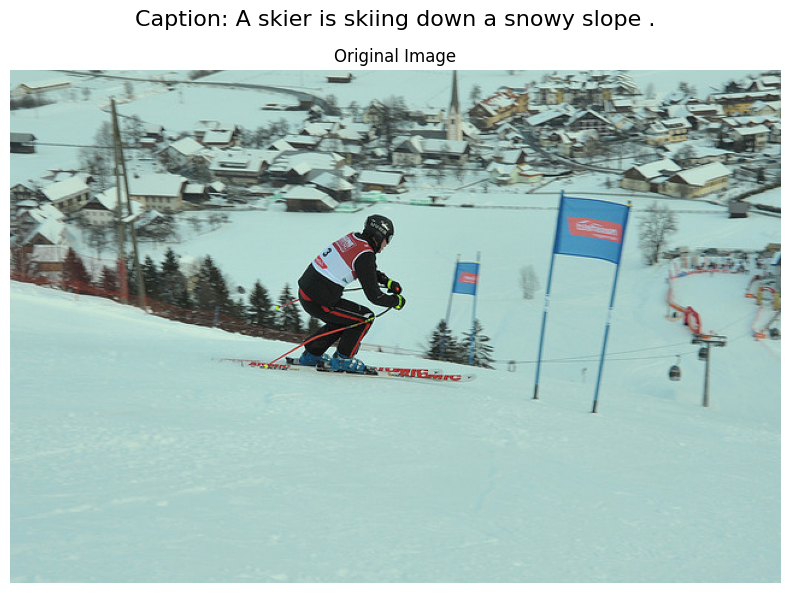

Image: 000000114340.jpg
Caption: Two boxes of donuts on a table with a table with two <unk> on them .



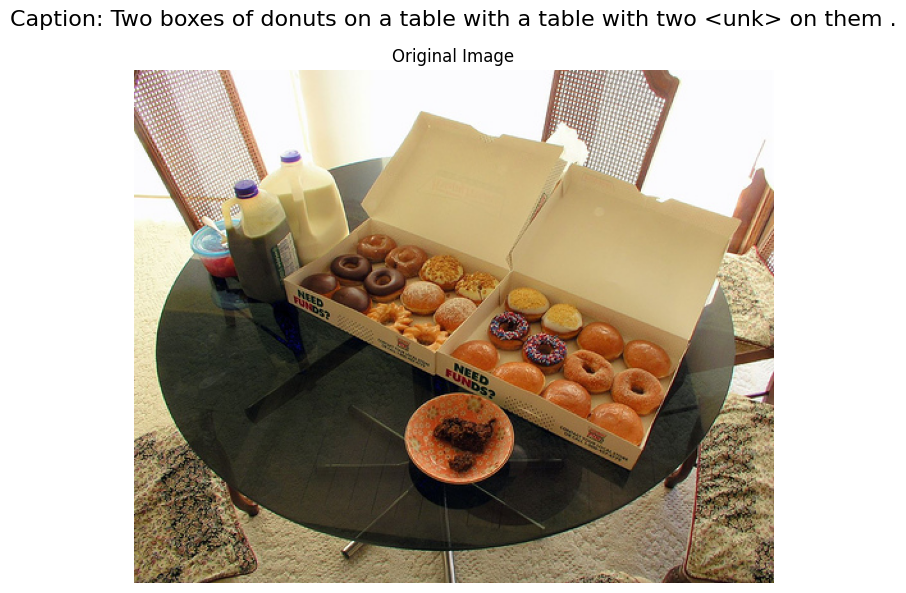

Image: 000000410627.jpg
Caption: A man is putting his food in a kitchen .



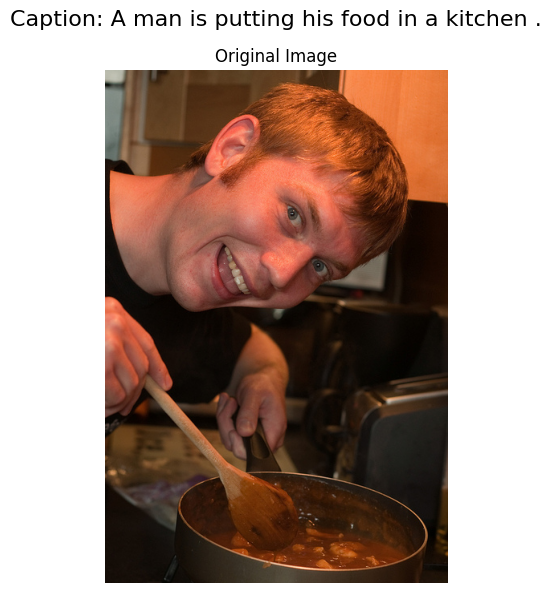

In [ ]:
test_on_random_coco_images(5)

Image: test2.jpeg
Caption: A group of people are sitting on a surf board .



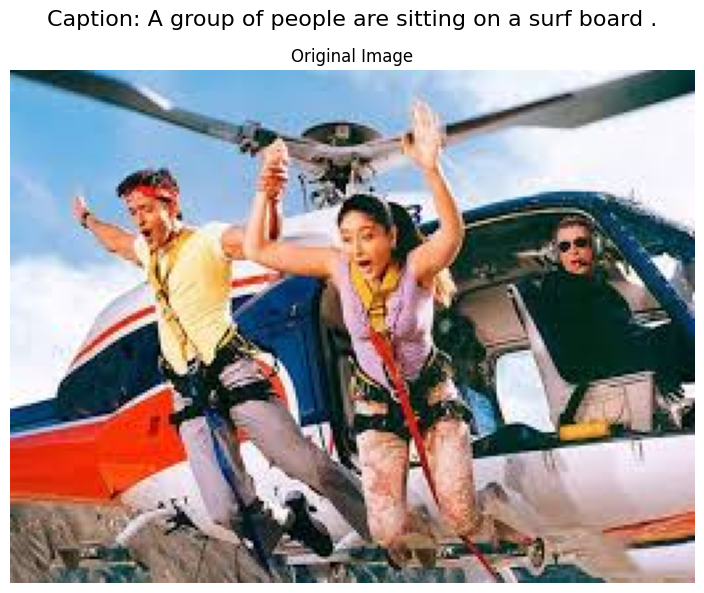

Image: images.jpeg
Caption: A dog sitting on a chair looking out of a window .



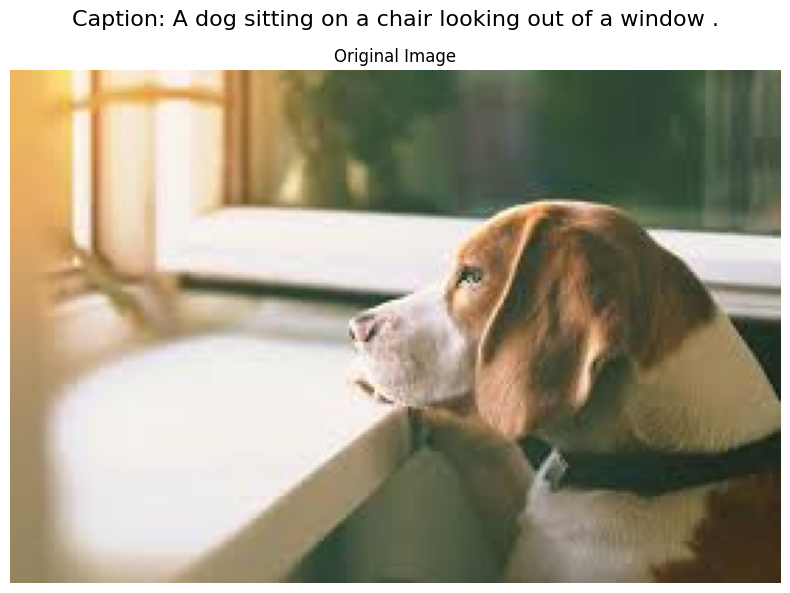

In [ ]:
# Test on images
# You can provide paths to your test images
test_images = [
    # Add paths to your test images here, for example:
    '/content/drive/MyDrive/image_captioning_project/test_images/test2.jpeg',
    '/content/drive/MyDrive/image_captioning_project/test_images/images.jpeg',
]
test_on_images(test_images)

Image: test_image_1.jpg
Caption: Two dogs are standing in a field with a <unk> .



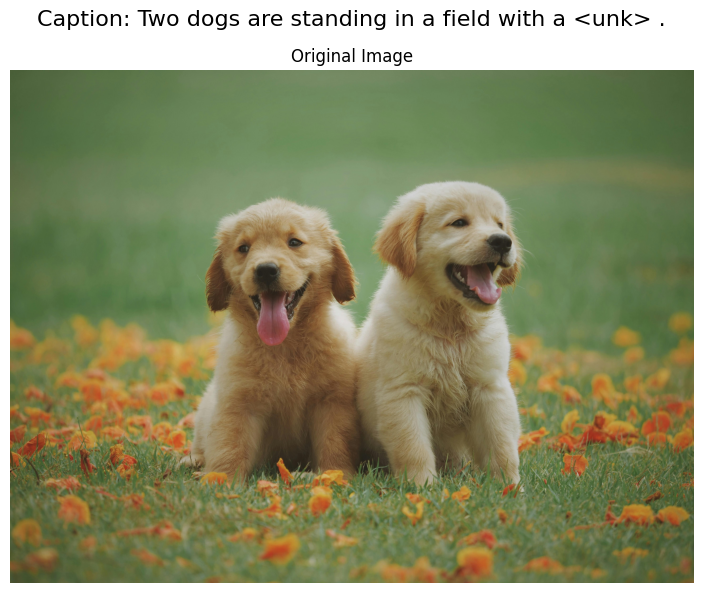

Image: test_image_2.jpg
Caption: A cat sitting on top of a table next to a computer .



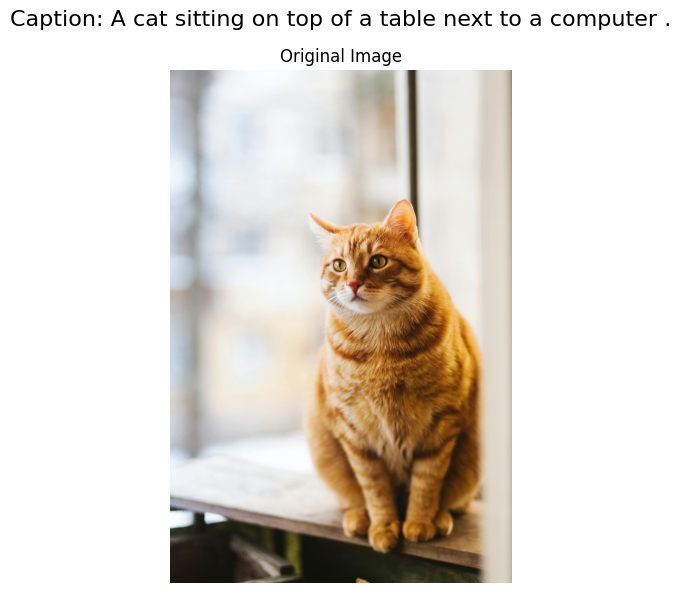

Image: test_image_3.jpg
Caption: Two women sitting on a bench in the shade of a house .



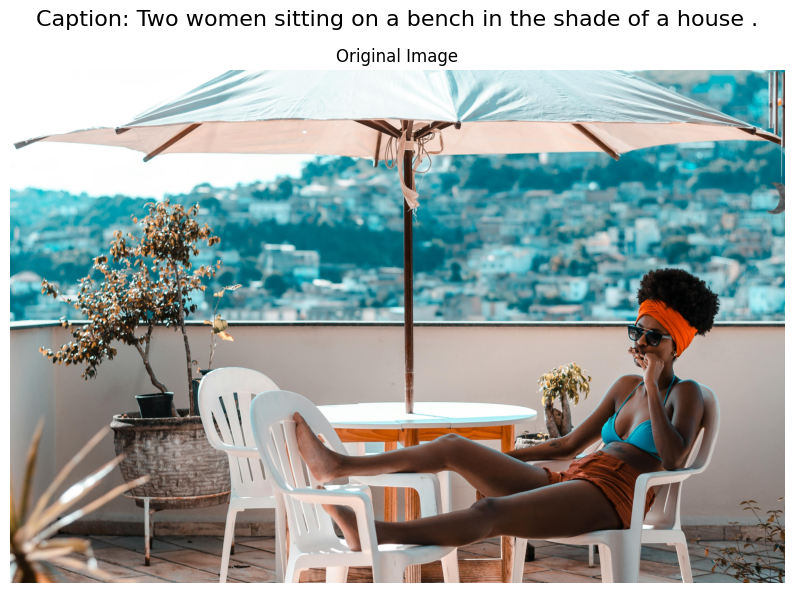

Image: test_image_4.jpg
Caption: A bowl of food is being cooked on a table .



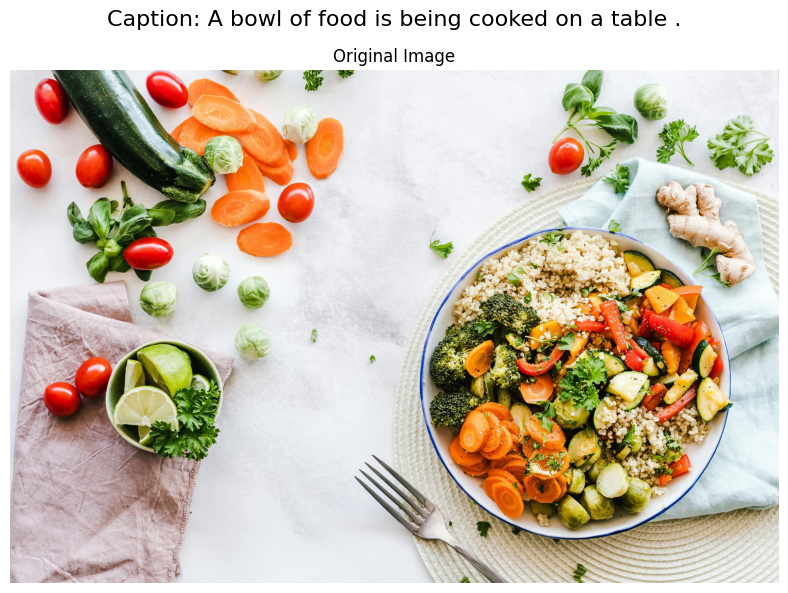

Image: test_image_5.jpg
Caption: A white dog sitting on top of a blanket .



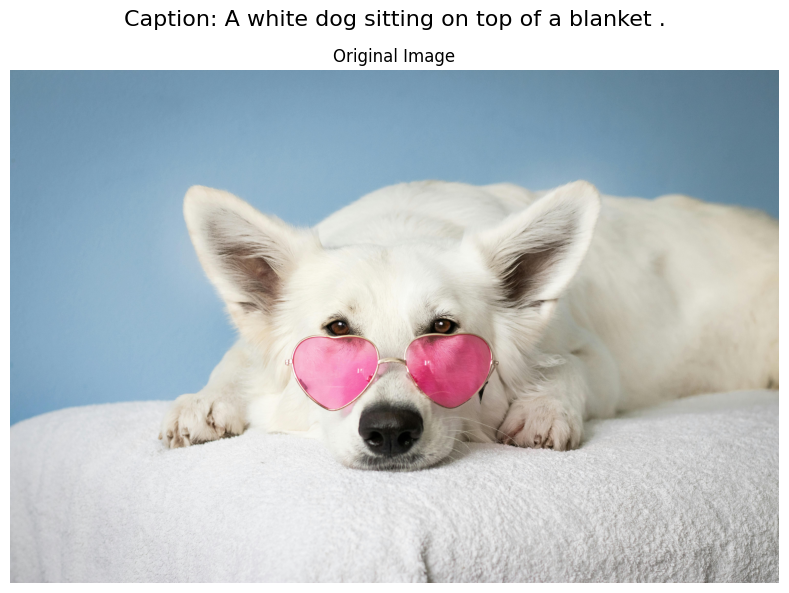

In [ ]:
test_images = [
    # Add paths to your test images here, for example:
    '/content/drive/MyDrive/image_captioning_project/test_images/test_image_1.jpg',
    '/content/drive/MyDrive/image_captioning_project/test_images/test_image_2.jpg',
    '/content/drive/MyDrive/image_captioning_project/test_images/test_image_3.jpg',
    '/content/drive/MyDrive/image_captioning_project/test_images/test_image_4.jpg',
    '/content/drive/MyDrive/image_captioning_project/test_images/test_image_5.jpg',

]

test_on_images(test_images)

In [ ]:
#test

In [ ]:
#test

In [ ]:
#test

In [ ]:
#test

In [ ]:
#test

In [ ]:
#test

In [ ]:
#test

In [ ]:
#test